# Fraud Detection on Amazon SageMaker

Consider a scenario in which customers make transactions over time on terminals spread out in space.\
Our aim is to build a system which detects whether or not a transaction is fraudulent.

### Entities

__Customers__
- geo coordinates
- spending behavior
- available terminals (we assume customers only make transactions on terminals that are within a radius of _RADIUS_ of their geo)

__Terminals__
- geo coordinates

__Transactions__
- date
- customer
- terminal
- amount
- label: legitimate (0) or fraudulent (1)

#### Notes

The simulated datasets will highlight most of the issues that practitioners of fraud detection face using real-world data. In particular, they will include __class imbalance__ (less than 1% of fraudulent transactions), a mix of __numerical and categorical features__, non-trivial __relationships between features__, and __time-dependent__ fraud scenarios.

In [1]:
!pip install pandas --upgrade
from functions import *

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


### Customers generation

In [2]:
customers_df = generate_customers(5000)
customers_df

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day
0,0,54.881350,71.518937,62.262521,31.131260,2.179533
1,1,42.365480,64.589411,46.570785,23.285393,3.567092
2,2,96.366276,38.344152,80.213879,40.106939,2.115580
3,3,56.804456,92.559664,11.748426,5.874213,0.348517
4,4,2.021840,83.261985,78.924891,39.462446,3.480049
...,...,...,...,...,...,...
4995,4995,12.375517,17.019679,55.866496,27.933248,2.675127
4996,4996,35.939285,89.252690,14.027825,7.013912,2.624998
4997,4997,16.603635,82.777873,55.996740,27.998370,2.114857
4998,4998,60.694863,70.530362,95.587319,47.793660,2.992698


### Terminals generation

In [3]:
terminals_df = generate_terminals(10000)
terminals_df

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,54.881350,71.518937
1,1,60.276338,54.488318
2,2,42.365480,64.589411
3,3,43.758721,89.177300
4,4,96.366276,38.344152
...,...,...,...
9995,9995,53.680779,52.871417
9996,9996,60.694863,70.530362
9997,9997,95.355073,74.817451
9998,9998,29.826661,44.645576


Let's take a look at a customer and the terminals available to them

CUSTOMER_ID            3.000000
x_customer_id         56.804456
y_customer_id         92.559664
mean_amount           11.748426
std_amount             5.874213
mean_nb_tx_per_day     0.348517
Name: 3, dtype: float64


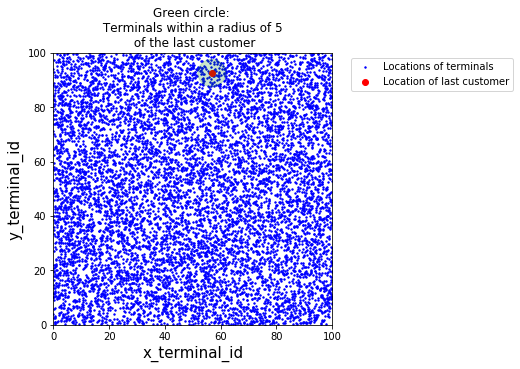

In [4]:
customer = customers_df.iloc[3]
print(customer)
RADIUS = 5
plot_customer_terminals(customer.x_customer_id, customer.y_customer_id, terminals_df, radius=RADIUS)

Let's associate terminals to customers

In [5]:
x_y_terminals = terminals_df[['x_terminal_id','y_terminal_id']].values.astype(float)
customers_df['available_terminals'] = customers_df.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=RADIUS), axis=1)
customers_df['nb_terminals']=customers_df.available_terminals.apply(len)
customers_df

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals
0,0,54.881350,71.518937,62.262521,31.131260,2.179533,"[0, 177, 251, 268, 682, 761, 785, 952, 958, 13...",67
1,1,42.365480,64.589411,46.570785,23.285393,3.567092,"[2, 62, 674, 745, 756, 928, 1369, 1491, 1500, ...",64
2,2,96.366276,38.344152,80.213879,40.106939,2.115580,"[4, 321, 383, 403, 624, 666, 1019, 1338, 1510,...",75
3,3,56.804456,92.559664,11.748426,5.874213,0.348517,"[6, 44, 104, 174, 263, 283, 432, 714, 807, 974...",75
4,4,2.021840,83.261985,78.924891,39.462446,3.480049,"[8, 605, 647, 856, 896, 1214, 1837, 1868, 1871...",68
...,...,...,...,...,...,...,...,...
4995,4995,12.375517,17.019679,55.866496,27.933248,2.675127,"[357, 369, 392, 407, 771, 834, 857, 861, 983, ...",75
4996,4996,35.939285,89.252690,14.027825,7.013912,2.624998,"[88, 125, 243, 252, 362, 746, 774, 966, 1116, ...",82
4997,4997,16.603635,82.777873,55.996740,27.998370,2.114857,"[75, 77, 165, 444, 777, 843, 911, 943, 967, 99...",86
4998,4998,60.694863,70.530362,95.587319,47.793660,2.992698,"[257, 268, 308, 319, 521, 780, 785, 958, 975, ...",67


### Transactions generation

Let's generate transactions for customers

In [6]:
NUMBER_OF_DAYS = 183
transactions_df = customers_df.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions(x.iloc[0], nb_days=NUMBER_OF_DAYS)).reset_index(drop=True)
transactions_df

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,2021-07-01 07:19:05,0,6958,123.59,26345,0
1,2021-07-01 19:02:02,0,7583,46.51,68522,0
2,2021-07-01 18:00:16,0,761,77.34,64816,0
3,2021-07-02 15:13:02,0,5802,32.35,141182,1
4,2021-07-02 14:05:38,0,9734,63.30,137138,1
...,...,...,...,...,...,...
1754150,2021-12-29 17:06:15,4999,5206,5.65,15699975,181
1754151,2021-12-29 06:23:51,4999,7567,20.08,15661431,181
1754152,2021-12-30 08:07:27,4999,9554,14.96,15754047,182
1754153,2021-12-30 04:32:41,4999,4801,52.18,15741161,182


Let's plot the generated transactions over time

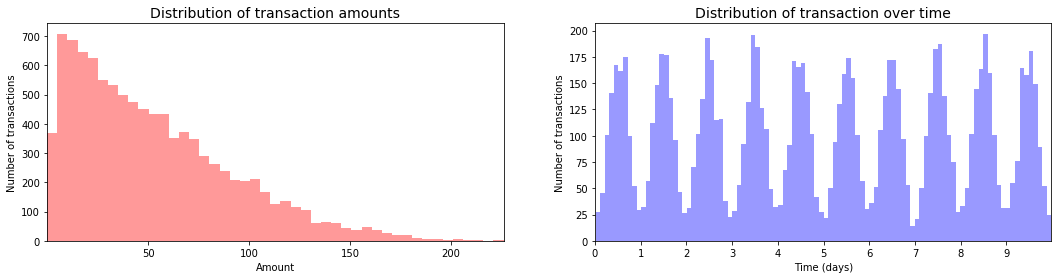

In [7]:
plot_transactions_over_time(transactions_df)

Let's add the fraudulent label to the transactions according to 3 scenarios:
- __Scenario 1__: any transaction whose amount is more than 220. This will provide an obvious fraud pattern that should be detected always.
- __Scenario 2__: every day, a list of two terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent.
- __Scenario 3__: every day, a list of 3 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and marked as fraudulent.


In [8]:
transactions_df = add_frauds(customers_df, terminals_df, transactions_df)

Number of frauds from scenario 1: 978
Number of frauds from scenario 2: 9177
Number of frauds from scenario 3: 4602
Fraudulent transactions: 14757/1754155 : 0.8%


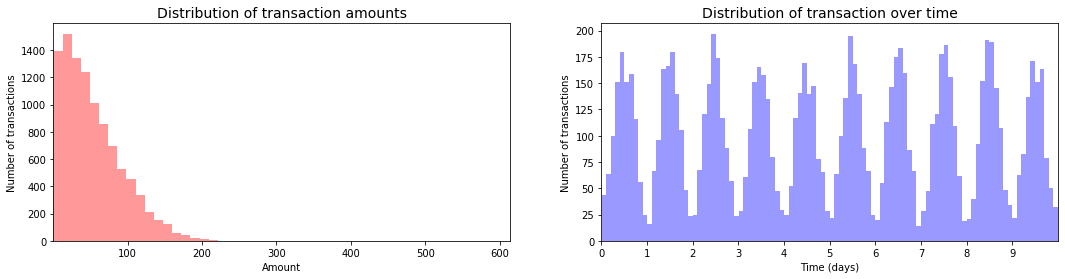

In [9]:
plot_transactions_over_time(transactions_df)

Let's plot some statistics of the transactions

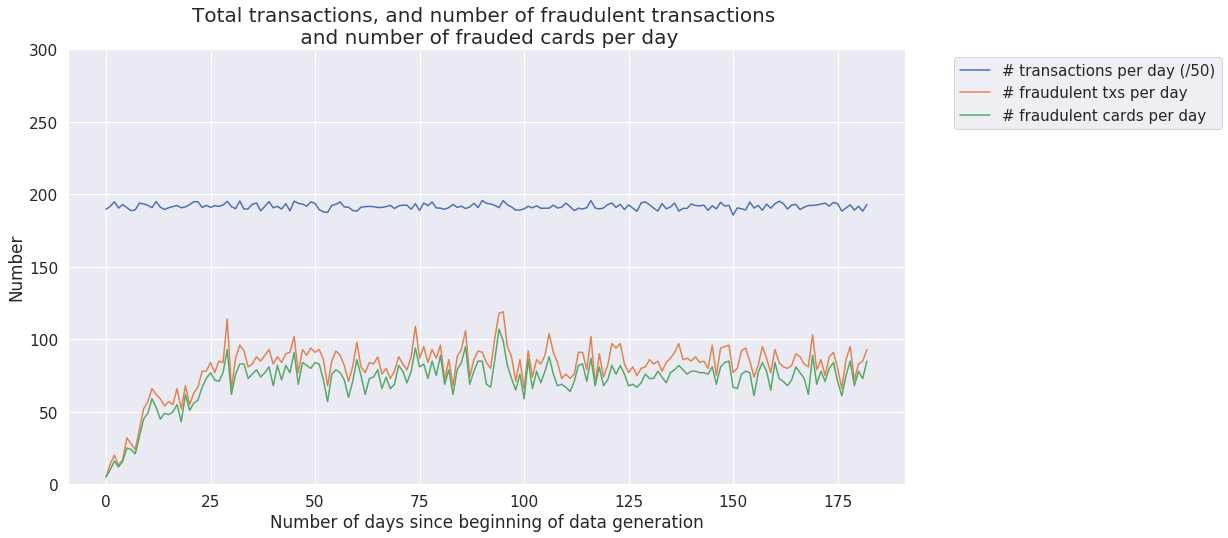

In [10]:
plot_transactions_stats(transactions_df)